# 数据表达与特征工程
## 数据表达
### 使用亚变量转化类型特征

In [1]:
import pandas as pd
fruits = pd.DataFrame({'数值特征':[5,6,7,8,9],
                   '类型特征':['西瓜','香蕉','桔子','苹果','葡萄']})
display(fruits)

,数值特征,类型特征
0,5,西瓜
1,6,香蕉
2,7,桔子
3,8,苹果
4,9,葡萄


In [2]:
fruits_dum = pd.get_dummies(fruits)
display(fruits_dum)

,数值特征,类型特征_桔子,类型特征_苹果,类型特征_葡萄,类型特征_西瓜,类型特征_香蕉
0,5,0,0,0,1,0
1,6,0,0,0,0,1
2,7,1,0,0,0,0
3,8,0,1,0,0,0
4,9,0,0,1,0,0


In [3]:
# 使用astype更加安全
fruits['数值特征'] = fruits['数值特征'].astype(str)
pd.get_dummies(fruits, columns=['数值特征'])

,类型特征,数值特征_5,数值特征_6,数值特征_7,数值特征_8,数值特征_9
0,西瓜,1,0,0,0,0
1,香蕉,0,1,0,0,0
2,桔子,0,0,1,0,0
3,苹果,0,0,0,1,0
4,葡萄,0,0,0,0,1


### 对数据进行装箱处理
不同算法建立的模型差别很大，例如KNN和MLP，让我们感受一下:

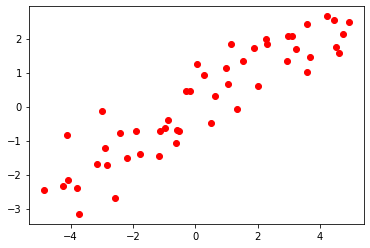

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# 生成随机数列
rnd = np.random.RandomState(38)
x = rnd.uniform(-5,5,size=50)
# 添加噪声
y_no_noise = (np.cos(6*x)+x)
X = x.reshape(-1,1)
y = (y_no_noise + rnd.normal(size=len(x)))/2
# 绘图
plt.plot(X,y,'o',c='r')
plt.show()

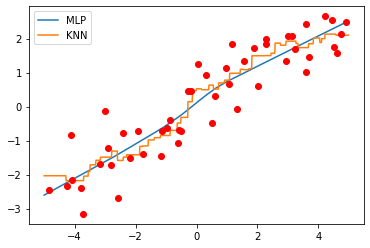

In [8]:
# 导入MLP
from sklearn.neural_network import MLPRegressor
# 导入KNN
from sklearn.neighbors import KNeighborsRegressor
# 生成等差数列
line = np.linspace(-5,5,1000,endpoint=False).reshape(-1,1)
# 分别拟合
mlpr = MLPRegressor().fit(X,y)
knr = KNeighborsRegressor().fit(X,y)
#绘图
plt.plot(line, mlpr.predict(line),label='MLP')
plt.plot(line, knr.predict(line),label='KNN')
plt.plot(X,y,'o',c='r')
plt.legend(loc='best')
plt.show()

那么我们应当用那种算法的预测结果呢？让我们先对数据进行装箱处理(binning)，也称为离散化处理(discretization)。

In [12]:
my_bins = np.linspace(-5,5,11)
target_bin = np.digitize(X, bins=my_bins)
print('装箱数据范围：\n{}'.format(my_bins))
print('\n前十个数据点的特征值：\n{}'.format(X[:10]))
print('\n前十个数据点所在的箱子：\n{}'.format(target_bin[:10]))

装箱数据范围：
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]

前十个数据点的特征值：
[[-1.1522688 ]
 [ 3.59707847]
 [ 4.44199636]
 [ 2.02824894]
 [ 1.33634097]
 [ 1.05961282]
 [-2.99873157]
 [-1.12612112]
 [-2.41016836]
 [-4.25392719]]

前十个数据点所在的箱子：
[[ 4]
 [ 9]
 [10]
 [ 8]
 [ 7]
 [ 7]
 [ 3]
 [ 4]
 [ 3]
 [ 1]]


In [13]:
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder类似于pandas的get_dummies，但只支持整数型
onehot = OneHotEncoder(sparse = False)
onehot.fit(target_bin)
X_in_bin = onehot.transform(target_bin)
print('装箱前的数据形态：{}'.format(target_bin.shape))
print('装箱后的数据形态：{}'.format(X_in_bin.shape))
print('\n装箱后的前十个数据点：\n{}'.format(X_in_bin[:10]))

装箱前的数据形态：(50, 1)
装箱后的数据形态：(50, 10)

装箱后的前十个数据点：
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**结果分析**: 样本数量没变，但是特征数量变成了10个，因为有10个箱子。这样相当于把连续特征转化成了类别特征。现在再来看看MLP和KNN发生了什么变化:

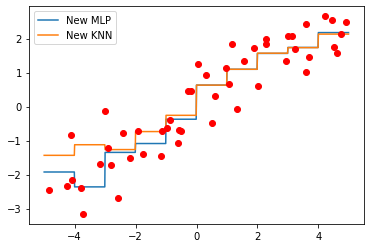

In [14]:
new_line = onehot.transform(np.digitize(line,bins=my_bins))

new_mlpr = MLPRegressor().fit(X_in_bin, y)
new_knr = KNeighborsRegressor().fit(X_in_bin,y)

plt.plot(line, new_mlpr.predict(new_line),label='New MLP')
plt.plot(line, new_knr.predict(new_line),label='New KNN')

plt.plot(X,y,'o',c='r')
plt.legend(loc='best')
plt.show()

模型变得更为相似。装箱可以纠正模型的过拟合或者欠拟合问题，尤其是针对大规模高维度数据集使用线性模型的时候，可以大幅提高线性模型的预测准确率。  
**注意**: 装箱操作对于基于决策树的算法没有太多作用，因为这类算法本身就在不停的拆分样本特征数据，所以不需要装箱操作。

## 数据“升维”
如果数据集特征不足，则需要进行扩充，常用的方法包括添加交互式特征(interaction features)和多项式特征(polynomial features)
### 向数据集添加交互式特征


In [19]:
array_1 = [1,2,3,4,5]
array_2 = [6,7,8,9,0]
array_3 = np.hstack((array_1, array_2))
print('将数组2添加到数据1中后得到:{}'.format(array_3))
# 如果array_1和array_2代表两个数据点的特征，那么array_3就是它们的交互特征。

将数组2添加到数据1中后得到:[1 2 3 4 5 6 7 8 9 0]


In [20]:
# 原始数据和装箱数据进行堆叠
X_stack = np.hstack([X, X_in_bin])
X_stack.shape

(50, 11)

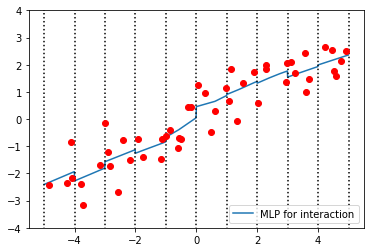

In [21]:
# 堆叠后的数据训练模型
line_stack = np.hstack([line, new_line])
mlpr_interact = MLPRegressor().fit(X_stack, y)
plt.plot(line, mlpr_interact.predict(line_stack), 
         label='MLP for interaction')
plt.ylim(-4,4)
for vline in my_bins:
    plt.plot([vline,vline],[-5,5],':',c='k')
plt.legend(loc='lower right')
plt.plot(X, y,'o',c='r')
plt.show()
# 每个箱体的斜率相同，这不是我们想要的

In [22]:
X_multi = np.hstack([X_in_bin, X*X_in_bin])
print(X_multi.shape)
print(X_multi[0])

(50, 20)
[ 0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        -0.        -0.
 -0.        -1.1522688 -0.        -0.        -0.        -0.
 -0.        -0.       ]


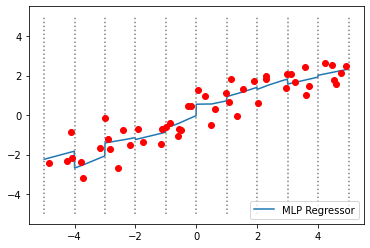

In [23]:
mlpr_multi = MLPRegressor().fit(X_multi, y)
line_multi = np.hstack([new_line, line * new_line])
plt.plot(line, mlpr_multi.predict(line_multi), label = 'MLP Regressor')
for vline in my_bins:
    plt.plot([vline,vline],[-5,5],':',c='gray')
plt.plot(X, y, 'o', c='r')
plt.legend(loc='lower right')
plt.show()
# 模型更为复杂，可以让欠拟合的模型有更好的表现

### 向数据集添加多项式特征
多项式:  
$$ax^4+bx^3+cx^2+dx+e$$

In [24]:
from sklearn.preprocessing import PolynomialFeatures
# 添加多项式特征
poly = PolynomialFeatures(degree=5, include_bias = False)
X_poly = poly.fit_transform(X)
print (X_poly.shape)

(50, 5)


In [25]:
print('原始数据集中的第一个样本特征：\n{}'.format(X[0]))
print('\n处理后的数据集中第一个样本特征：\n{}'.format(X_poly[0]))

原始数据集中的第一个样本特征：
[-1.1522688]

处理后的数据集中第一个样本特征：
[-1.1522688   1.3277234  -1.52989425  1.76284942 -2.0312764 ]


In [26]:
print ('PolynomialFeatures对原始数据的处理:\n{}'.format(
    poly.get_feature_names_out()))

PolynomialFeatures对原始数据的处理:
['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5']


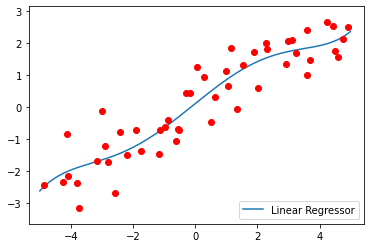

In [27]:
from sklearn.linear_model import LinearRegression

LNR_poly = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)

plt.plot(line,LNR_poly.predict(line_poly), label='Linear Regressor')
plt.xlim(np.min(X)-0.5,np.max(X)+0.5)
plt.ylim(np.min(y)-0.5,np.max(y)+0.5)
plt.plot(X,y,'o',c='r')
plt.legend(loc='lower right')
plt.show()

## 自动特征选择
### 使用单一变量法进行特征选择

In [28]:
import pandas as pd
stock = pd.read_csv('2019.csv',encoding='GBK')
display(stock.head()) 

,代码,名称,涨幅%,现价,涨跌,买价,总量,现量,涨速%,换手%,...,每股净资,调整后净资,每股公积,每股未分配,每股现金流,权益比%,营业利润率%,净利润率%,研发费用(亿),员工人数
0,1,平安银行,0.67,16.45,0.11,16.44,557918,6364,0.24,0.29,...,13.82,13.82,4.16,5.94,4.35,7.77,29.83,22.94,0.00,33529
1,2,万 科Ａ,-0.26,26.42,-0.07,26.41,368124,1537,0.08,0.38,...,14.80,0.00,1.06,8.68,0.15,10.21,18.74,8.15,5.37,104300
2,4,国农科技,-0.49,18.35,-0.09,18.35,4882,98,0.00,0.59,...,1.18,0.00,0.01,0.04,-0.12,76.39,-4.30,-9.19,0.03,210
3,5,世纪星源,1.04,2.91,0.03,2.91,37922,780,0.00,0.36,...,1.45,0.00,0.65,-0.24,0.12,50.15,12.15,7.82,0.17,745
4,6,深振业Ａ,0.40,5.08,0.02,5.08,40357,164,0.20,0.30,...,4.73,0.00,0.36,2.27,0.35,41.23,30.41,23.01,0.00,377


In [29]:
y = stock['涨幅%']
print(y.shape)
print(y[0])

(3699,)
0.67


In [32]:
features = stock.loc[:,'现价':'流通股(亿)']
X = features.values
print(X.shape)
print(X[:1])

(3699, 22)
[[1.64500e+01 1.10000e-01 1.64400e+01 5.57918e+05 6.36400e+03 2.40000e-01
  2.90000e-01 1.63500e+01 1.65500e+01 1.62300e+01 1.63400e+01 8.80000e-01
  1.96000e+00 1.64200e+01 2.81412e+05 2.76506e+05 1.02000e+00 1.31100e+03
  1.11700e+03 4.34960e+06 0.00000e+00 1.94060e+02]]


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mlpr=MLPRegressor(random_state=18, hidden_layer_sizes=(100,100),alpha=0.001)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=62)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlpr.fit(X_train_scaled, y_train)
print('模型准确率：{:.2f}'.format(mlpr.score(X_test_scaled,y_test)))

模型准确率：0.65


In [34]:
# 涨幅大于10的股票
wanted = stock.loc[:,'名称']
print(wanted[y>=10])

29       深大通
216     天夏智慧
350     国风塑业
499     国光电器
663     南洋股份
767     久立特材
801     杰瑞股份
948     鼎龙文化
1381    瑞达期货
1386    广电计量
1481     易联众
1482    智云股份
1502    东方日升
1723    麦克奥迪
1778     京天利
1873    盛天网络
1922    联得装备
2017    透景生命
2027    正海生物
2161    钢研纳克
2162    左江科技
2164    矩子科技
2165    N指南针
2717    航天通信
2764    鲁北化工
2863    界龙实业
3224    南华期货
3241    华培动力
3384    八方股份
3575    永悦科技
3678     N金山
Name: 名称, dtype: object


In [35]:
from sklearn.feature_selection import SelectPercentile
select = SelectPercentile(percentile=50)
select.fit(X_train_scaled, y_train)
X_train_selected = select.transform(X_train_scaled)
print('经过缩放的特征形态：{}'.format(X_train_scaled.shape))
print('特征选择后的特征形态:{}'.format(X_train_selected.shape))

经过缩放的特征形态：(2774, 22)
特征选择后的特征形态:(2774, 11)


In [38]:
# 查看哪些特征被保留下来
mask = select.get_support()
print(mask)

[False  True False False  True  True  True False  True False False  True
  True False False False  True  True False  True  True False]


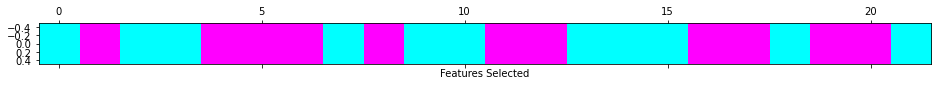

In [39]:
plt.matshow(mask.reshape(1,-1),cmap=plt.cm.cool)
plt.xlabel("Features Selected")
plt.show()

In [40]:
X_test_selected = select.transform(X_test_scaled)
mlpr_sp=MLPRegressor(random_state=18, hidden_layer_sizes=(100,100),
                      alpha=0.001)
mlpr_sp.fit(X_train_selected, y_train)
print('特征选择后模型得分：{:.2f}'.format(mlpr_sp.score(X_test_selected, 
                                              y_test)))

特征选择后模型得分：0.97


### 基于模型的特征选择

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
sfm = SelectFromModel(RandomForestRegressor(n_estimators=100, 
                                            random_state=18),
                     threshold='median')
sfm.fit(X_train_scaled, y_train)
X_train_sfm = sfm.transform(X_train_scaled)
print('基于随机森林模型进行特征后的数据形态：{}'.format(X_train_sfm.shape))

基于随机森林模型进行特征后的数据形态：(2774, 11)


In [43]:
mask_sfm = sfm.get_support()
print(mask_sfm)

[False  True False False  True False  True  True False  True  True  True
  True False False False  True  True  True False False False]


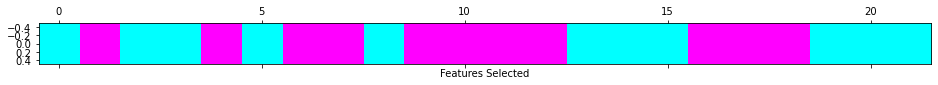

In [44]:
plt.matshow(mask_sfm.reshape(1,-1),cmap=plt.cm.cool)
plt.xlabel('Features Selected')
plt.show()

In [45]:
X_test_sfm = sfm.transform(X_test_scaled)
mlpr_sfm=MLPRegressor(random_state=18, hidden_layer_sizes=(100,100),
                      alpha=0.001)
mlpr_sfm.fit(X_train_sfm, y_train)
print('随机森林进行特征选择后的模型得分：{:.2f}'.format(
    mlpr_sfm.score(X_test_sfm, y_test)))

随机森林进行特征选择后的模型得分：0.84


### 迭代式特征选择

In [46]:
from sklearn.feature_selection import RFE
rfe = RFE(RandomForestRegressor(n_estimators=100,
                                 random_state=18),
         n_features_to_select=12)
rfe.fit(X_train_scaled, y_train)
mask = rfe.get_support()
print(mask)

[False  True False False  True False  True  True False  True  True  True
  True  True False False  True  True  True False False False]


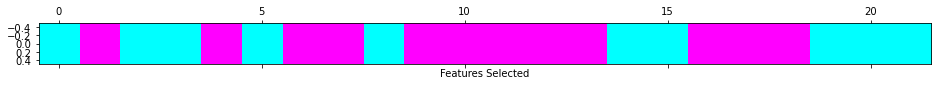

In [47]:
plt.matshow(mask.reshape(1,-1), cmap=plt.cm.cool)
plt.xlabel('Features Selected')
plt.show()

In [48]:
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
mlpr_rfe = MLPRegressor(random_state=18, hidden_layer_sizes=(100,100),
                      alpha=0.001)
mlpr_rfe.fit(X_train_rfe, y_train)
print("RFE选择特征后的模型得分：{:.2f}".format(mlpr_rfe.score(X_test_rfe,
                                                  y_test)))

RFE选择特征后的模型得分：0.87


In [36]:
print('{:.2f}'.format(rfe.score(X_test_scaled, y_test)))

0.20
